# Import libraries

In [10]:
## Import libraries for machine learning and data processing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
# import tensorflow as tf
# import os

# def setup_hardware(use_cpu_only=False):
#     """
#     Configures TensorFlow hardware settings. 
#     MUST be called at the very beginning of the script before ANY other TF operations.
#     """
#     if use_cpu_only:
#         # 1. Environment variable approach (The most 'forceful' way)
#         # This tells the low-level C++ backend to ignore GPUs before it even starts.
#         os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
        
#         # 2. Config approach
#         try:
#             tf.config.set_visible_devices([], 'GPU')
#             print("\n[STABILITY MODE] GPU disabled via software config.")
#         except RuntimeError:
#             # If this fails, the environment variable usually still catches it
#             print("\n[STABILITY MODE] GPU already initialized, but environment var is set to CPU.")
#     else:
#         # Logic for GPU mode
#         try:
#             # We list devices but immediately configure them
#             gpus = tf.config.list_physical_devices('GPU')
#             if gpus:
#                 for gpu in gpus:
#                     # On M2 Macs, this is critical to avoid 'Out of Memory' crashes
#                     tf.config.experimental.set_memory_growth(gpu, True)
#                 print(f"[GPU MODE] Found {len(gpus)} GPU(s). Memory growth enabled.")
#             else:
#                 print("[INFO] No GPU found. Falling back to CPU.")
#         except RuntimeError as e:
#             # If you see this, something called a TF function before this script ran.
#             print(f"\n[!] WARNING: Hardware already initialized. Could not set memory growth.")
#             print(f"Error Details: {e}")

# # --- HOW TO USE THIS IN YOUR MAIN SCRIPT ---
# # import tensorflow as tf
# # from tf_hardware_setup import setup_hardware
# #
# setup_hardware(use_cpu_only=True) 



[STABILITY MODE] GPU already initialized, but environment var is set to CPU.


In [ ]:
# import sys, importlib, site
# print("sys.executable:", sys.executable)
# print("sys.version:", sys.version)
# print("sys.path (first 8):", sys.path[:8])
# print("site.getsitepackages():", getattr(site, 'getsitepackages', lambda: None)())
# print("USER site:", site.USER_SITE)
# print("find tensorflow spec:", importlib.util.find_spec('tensorflow'))

sys.executable: /Users/adityaponnada/Documents/codework/real_time_prompting/real_time_prompting/tfpy/bin/python
sys.version: 3.11.14 (main, Oct  9 2025, 16:16:55) [Clang 17.0.0 (clang-1700.4.4.1)]
sys.path (first 8): ['/opt/homebrew/Cellar/python@3.11/3.11.14_1/Frameworks/Python.framework/Versions/3.11/lib/python311.zip', '/opt/homebrew/Cellar/python@3.11/3.11.14_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11', '/opt/homebrew/Cellar/python@3.11/3.11.14_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/lib-dynload', '', '/Users/adityaponnada/Documents/codework/real_time_prompting/real_time_prompting/tfpy/lib/python3.11/site-packages', '/Users/adityaponnada/Documents/codework/real_time_prompting/real_time_prompting/tfpy/lib/python3.11/site-packages/setuptools/_vendor']
site.getsitepackages(): ['/Users/adityaponnada/Documents/codework/real_time_prompting/real_time_prompting/tfpy/lib/python3.11/site-packages']
USER site: /Users/adityaponnada/Library/Python/3.11/lib/pyt

# Read data

In [11]:
## import dataset
raw_feature_df_scaled = pd.read_csv('/Users/adityaponnada/Downloads/time_study_data/processed_features_rnn.csv')
## Display the first few rows of the dataset
raw_feature_df_scaled.head(5)

,participant_id,outcome,is_weekend,in_battery_saver_mode,charging_status,screen_on,dist_from_home,is_phone_locked,last_phone_usage,closeness_to_sleep_time,...,mi_time_of_day_Night,mi_location_category_Home,mi_location_category_Other,mi_location_category_School,mi_location_category_Transit,mi_location_category_Work,mi_wake_day_part_0.0,mi_wake_day_part_1.0,mi_wake_day_part_2.0,mi_wake_day_part_3.0
0,afflictedrevenueepilepsy@timestudy_com,0,0,0.0,0.0,0,0.006074,1.0,60.0,981.983333,...,0,0,0,0,0,0,0,0,0,0
1,afflictedrevenueepilepsy@timestudy_com,1,0,NaN,NaN,0,0.005902,1.0,60.0,973.966667,...,0,0,0,0,0,0,0,0,0,0
2,afflictedrevenueepilepsy@timestudy_com,1,0,0.0,0.0,0,0.005426,1.0,60.0,965.933333,...,0,0,0,0,0,0,0,0,0,0
3,afflictedrevenueepilepsy@timestudy_com,0,0,0.0,1.0,0,0.005985,1.0,60.0,947.966667,...,0,0,0,0,0,0,0,0,0,0
4,afflictedrevenueepilepsy@timestudy_com,0,0,0.0,1.0,0,0.006400,1.0,60.0,936.966667,...,0,0,0,0,0,0,0,0,0,0


In [12]:
raw_feature_df_scaled['outcome'].value_counts(normalize=True)

outcome
1    0.797685
0    0.202315
Name: proportion, dtype: float64

In [13]:
raw_feature_df_scaled['participant_id'].nunique()

100

### Discard missingness indicators for complete data

In [14]:
def drop_zero_mi_columns(df, mi_prefix='mi_', inplace=False, verbose=False):
    """
    Drop missingness-indicator columns whose non-null values are all zero.
    - Leaves columns that are entirely NaN.
    - Returns a DataFrame (copy by default) with those mi_* columns removed.
    """
    import pandas as pd
    if df is None or not isinstance(df, pd.DataFrame):
        raise ValueError("df must be a pandas DataFrame")

    if not inplace:
        df = df.copy()

    mi_cols = [c for c in df.columns if str(c).startswith(mi_prefix)]
    to_drop = []
    for c in mi_cols:
        non_null = df[c].dropna()
        # drop if there's at least one non-null value and all non-null values equal 0
        if len(non_null) > 0 and (non_null == 0).all():
            to_drop.append(c)

    if to_drop:
        if verbose:
            print(f"Dropping {len(to_drop)} columns: {to_drop}")
        df.drop(columns=to_drop, inplace=True)

    return df

raw_feature_df_scaled = drop_zero_mi_columns(raw_feature_df_scaled, mi_prefix='mi_', inplace=False, verbose=True)

Dropping 24 columns: ['mi_is_weekend', 'mi_screen_on', 'mi_days_in_study', 'mi_completion_24h', 'mi_completion_1h', 'mi_time_between_prompts', 'mi_time_since_last_answered', 'mi_completion_since_wake', 'mi_completion_since_start', 'mi_time_of_day_Afternoon', 'mi_time_of_day_Early Morning', 'mi_time_of_day_Evening', 'mi_time_of_day_Late Night', 'mi_time_of_day_Morning', 'mi_time_of_day_Night', 'mi_location_category_Home', 'mi_location_category_Other', 'mi_location_category_School', 'mi_location_category_Transit', 'mi_location_category_Work', 'mi_wake_day_part_0.0', 'mi_wake_day_part_1.0', 'mi_wake_day_part_2.0', 'mi_wake_day_part_3.0']


In [15]:
raw_feature_df_scaled.head()

,participant_id,outcome,is_weekend,in_battery_saver_mode,charging_status,screen_on,dist_from_home,is_phone_locked,last_phone_usage,closeness_to_sleep_time,...,wake_day_part_2.0,wake_day_part_3.0,mi_in_battery_saver_mode,mi_charging_status,mi_dist_from_home,mi_is_phone_locked,mi_last_phone_usage,mi_closeness_to_sleep_time,mi_closeness_to_wake_time,mi_mims_5min
0,afflictedrevenueepilepsy@timestudy_com,0,0,0.0,0.0,0,0.006074,1.0,60.0,981.983333,...,0,0,0,0,0,0,0,0,0,0
1,afflictedrevenueepilepsy@timestudy_com,1,0,NaN,NaN,0,0.005902,1.0,60.0,973.966667,...,0,0,1,1,0,0,0,0,0,0
2,afflictedrevenueepilepsy@timestudy_com,1,0,0.0,0.0,0,0.005426,1.0,60.0,965.933333,...,0,0,0,0,0,0,0,0,0,0
3,afflictedrevenueepilepsy@timestudy_com,0,0,0.0,1.0,0,0.005985,1.0,60.0,947.966667,...,0,0,0,0,0,0,0,0,0,0
4,afflictedrevenueepilepsy@timestudy_com,0,0,0.0,1.0,0,0.006400,1.0,60.0,936.966667,...,0,0,0,0,0,0,0,0,0,0


### Save column list for future use

In [16]:
## Save the column names as a txt file
with open('/Users/adityaponnada/Downloads/time_study_data/processed_feature_columns.txt', 'w') as f:
    for col in raw_feature_df_scaled.columns:
        f.write(f"{col}\n")

# Split training and test

In [17]:
def split_train_test_by_users_random(df, id_col='participant_id', n_train_users=10, random_state=None):
    """
    Randomly split a DataFrame into a train set containing all rows for a randomly
    selected set of `n_train_users` participants and a test set containing the
    remaining participants.

    Returns: (train_df, test_df) with indices reset.
    """
    import numpy as np
    import pandas as pd

    if id_col not in df.columns:
        raise ValueError(f"id_col '{id_col}' not found in DataFrame columns")

    unique_ids = pd.Index(df[id_col].dropna().unique())
    n_unique = len(unique_ids)
    if n_unique == 0:
        raise ValueError('No participant ids found in the DataFrame')
    if n_train_users <= 0 or n_train_users >= n_unique:
        raise ValueError(f'n_train_users must be >0 and < number of unique participants ({n_unique})')

    rng = np.random.default_rng(random_state)
    train_ids = rng.choice(unique_ids, size=n_train_users, replace=False)

    train_df = df[df[id_col].isin(train_ids)].reset_index(drop=True)
    test_df = df[~df[id_col].isin(train_ids)].reset_index(drop=True)

    return train_df, test_df

# Example usage:
train_df, test_df = split_train_test_by_users_random(raw_feature_df_scaled, n_train_users=10, random_state=42)

In [18]:
train_df.head()

,participant_id,outcome,is_weekend,in_battery_saver_mode,charging_status,screen_on,dist_from_home,is_phone_locked,last_phone_usage,closeness_to_sleep_time,...,wake_day_part_2.0,wake_day_part_3.0,mi_in_battery_saver_mode,mi_charging_status,mi_dist_from_home,mi_is_phone_locked,mi_last_phone_usage,mi_closeness_to_sleep_time,mi_closeness_to_wake_time,mi_mims_5min
0,bartenderradiatorapplied@timestudy_com,0,1,NaN,NaN,1,0.021014,NaN,NaN,828.966667,...,0,0,1,1,0,1,1,0,0,1
1,bartenderradiatorapplied@timestudy_com,0,1,NaN,NaN,1,0.019771,NaN,NaN,816.966667,...,0,0,1,1,0,1,1,0,0,1
2,bartenderradiatorapplied@timestudy_com,0,1,NaN,NaN,1,0.021419,NaN,NaN,808.983333,...,0,0,1,1,0,1,1,0,0,1
3,bartenderradiatorapplied@timestudy_com,0,1,NaN,NaN,1,0.021211,NaN,NaN,800.983333,...,0,0,1,1,0,1,1,0,0,1
4,bartenderradiatorapplied@timestudy_com,1,1,NaN,NaN,0,0.023365,NaN,NaN,773.966667,...,0,0,1,1,0,1,1,0,0,0


In [19]:
train_df['participant_id'].nunique(), test_df['participant_id'].nunique()

(10, 90)

# Missing data imputation

We will use fill forward (good for real time prediction) to get the last value. If the first value is NA for a participant, use median. The global training medians are saved for use with held out data

In [20]:
# Print the percentage of missing values for each column in train_df
missing_pct_train = train_df.isnull().mean() * 100
print("% Missing values per column in train_df:")
missing_pct_train.sort_values(ascending=False)

% Missing values per column in train_df:


in_battery_saver_mode         52.718143
charging_status               52.718143
dist_from_home                12.220473
is_phone_locked                5.727781
last_phone_usage               5.727781
mims_5min                      4.604353
closeness_to_sleep_time        1.420243
closeness_to_wake_time         1.420243
participant_id                 0.000000
wake_day_part_3.0              0.000000
location_category_School       0.000000
location_category_Transit      0.000000
location_category_Work         0.000000
wake_day_part_0.0              0.000000
wake_day_part_1.0              0.000000
wake_day_part_2.0              0.000000
mi_last_phone_usage            0.000000
mi_in_battery_saver_mode       0.000000
mi_charging_status             0.000000
mi_dist_from_home              0.000000
mi_is_phone_locked             0.000000
location_category_Home         0.000000
mi_closeness_to_sleep_time     0.000000
mi_closeness_to_wake_time      0.000000
location_category_Other        0.000000


In [21]:
# Print column dtypes using helper if available, else fallback to direct printing
if 'train_df' not in globals():
    print('train_df not found; run the split cell to create it first.')
else:
    if 'print_column_dtypes' in globals():
        print_column_dtypes(train_df, show_counts=True)
    else:
        print('print_column_dtypes not defined — printing dtypes and non-null counts directly')
        print(train_df.dtypes)

print_column_dtypes not defined — printing dtypes and non-null counts directly
participant_id                 object
outcome                         int64
is_weekend                      int64
in_battery_saver_mode         float64
charging_status               float64
screen_on                       int64
dist_from_home                float64
is_phone_locked               float64
last_phone_usage              float64
closeness_to_sleep_time       float64
closeness_to_wake_time        float64
mims_5min                     float64
days_in_study                 float64
completion_24h                float64
completion_1h                 float64
time_between_prompts          float64
time_since_last_answered      float64
completion_since_wake         float64
completion_since_start        float64
time_of_day_Afternoon           int64
time_of_day_Early Morning       int64
time_of_day_Evening             int64
time_of_day_Late Night          int64
time_of_day_Morning             int64
time_of_d

### Fill forward + hybrid imputation for training data

In [22]:
def impute_group_median_then_ffill(df, id_col='participant_id', outcome_col='outcome', mi_prefix='mi_', inplace=False, verbose=False):
    """Impute missing values per participant using group medians and forward-fill."""
    # Steps:
    # 1) Group by participant id.
    # 2) Ignore columns: id_col, outcome_col, and any column starting with mi_prefix.
    # 3) For remaining numeric columns: compute the group's median. If the first value in the
    #    group for that column is NaN, replace it with the group's median (fallback to global median if needed).
    # 4) For remaining NaNs in the group, use forward-fill (LOCF).
    # 5) After group-level processing, compute global medians for the processed columns and return them.
    import pandas as pd
    import numpy as np
    if df is None:
        raise ValueError('df must be a pandas DataFrame')
    if not inplace:
        df = df.copy()
    # Select columns to process (exclude id/outcome/mi_*)
    exclude = {id_col, outcome_col}
    cols_to_process = [c for c in df.columns if c not in exclude and not str(c).startswith(mi_prefix)]
    if verbose:
        print(f'Processing {len(cols_to_process)} columns (excluding {exclude} and prefix)')
    # Work only on numeric columns for median-based imputation; others we will still forward-fill if needed
    numeric_cols = df[cols_to_process].select_dtypes(include=[np.number]).columns.tolist()
    # Compute global medians for numeric columns
    global_medians = df[numeric_cols].median() if numeric_cols else pd.Series(dtype=float)
    # Group by participant and impute per-group
    if id_col in df.columns and numeric_cols:
        grouped = df.groupby(id_col, sort=False)
        for pid, idx in grouped.groups.items():
            for col in numeric_cols:
                s = df.loc[idx, col]
                # group median (may be NaN if group has no non-NaN values)
                try:
                    gm = grouped[col].median().get(pid, np.nan) if hasattr(grouped[col], 'median') else np.nan
                except Exception:
                    gm = np.nan
                if pd.isna(gm):
                    # fallback to global median if group median not available
                    gm = global_medians.get(col, np.nan)
                # If first value is NaN, set it to group median (or global median fallback)
                if not s.empty and pd.isna(s.iloc[0]):
                    if not pd.isna(gm):
                        df.loc[idx[0], col] = gm
                # Forward-fill within the group for remaining NaNs
                # Use transform-style assignment: compute filled series and write back only where original was NaN
                s_after_first = df.loc[idx, col]
                s_filled = s_after_first.fillna(method='ffill')
                mask = s_after_first.isna()
                if mask.any():
                    df.loc[idx, col] = s_filled
    else:
        # If id_col not present or no numeric columns, fall back to global strategies
        for col in numeric_cols:
            # if first value is NaN, replace with global median
            if df[col].isna().iloc[0]:
                gm = global_medians.get(col, np.nan)
                if not pd.isna(gm):
                    df.iloc[0, df.columns.get_loc(col)] = gm
            # forward-fill the rest
            df[col] = df[col].fillna(method='ffill')
    # After group-level imputation, any remaining NaNs in numeric_cols -> fill with global medians
    for col in numeric_cols:
        if df[col].isna().any():
            gm = global_medians.get(col, np.nan)
            if not pd.isna(gm):
                df[col] = df[col].fillna(gm)
    # Build medians dataframe to return (global medians for processed numeric columns)
    if not numeric_cols:
        medians_df = pd.DataFrame()
    else:
        medians_df = pd.DataFrame(global_medians).T.rename(index={0: 'global_median'})
    return df, medians_df

# Example usage: apply the imputer to train_df if available
if 'train_df' in globals():
    train_df, medians = impute_group_median_then_ffill(train_df, verbose=True)
    print('Returned medians (preview):')
    print(medians.head())
else:
    print('train_df not found; run the split cell to create it before imputing.')

Processing 32 columns (excluding {'outcome', 'participant_id'} and prefix)


/var/folders/h6/3rl340nn7cg92xvwk801_3b80000gn/T/ipykernel_2191/184998816.py:46: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s_filled = s_after_first.fillna(method='ffill')
/var/folders/h6/3rl340nn7cg92xvwk801_3b80000gn/T/ipykernel_2191/184998816.py:46: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s_filled = s_after_first.fillna(method='ffill')
/var/folders/h6/3rl340nn7cg92xvwk801_3b80000gn/T/ipykernel_2191/184998816.py:46: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s_filled = s_after_first.fillna(method='ffill')
/var/folders/h6/3rl340nn7cg92xvwk801_3b80000gn/T/ipykernel_2191/184998816.py:46: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() ins

Returned medians (preview):
               is_weekend  in_battery_saver_mode  charging_status  screen_on  \
global_median         0.0                    0.0              0.0        0.0   

               dist_from_home  is_phone_locked  last_phone_usage  \
global_median        0.015463              1.0               9.1   

               closeness_to_sleep_time  closeness_to_wake_time  mims_5min  \
global_median               464.916667              467.066667  30.571034   

               ...  time_of_day_Night  location_category_Home  \
global_median  ...                0.0                     1.0   

               location_category_Other  location_category_School  \
global_median                      0.0                       0.0   

               location_category_Transit  location_category_Work  \
global_median                        0.0                     0.0   

               wake_day_part_0.0  wake_day_part_1.0  wake_day_part_2.0  \
global_median                0.0        

/var/folders/h6/3rl340nn7cg92xvwk801_3b80000gn/T/ipykernel_2191/184998816.py:46: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s_filled = s_after_first.fillna(method='ffill')
/var/folders/h6/3rl340nn7cg92xvwk801_3b80000gn/T/ipykernel_2191/184998816.py:46: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s_filled = s_after_first.fillna(method='ffill')
/var/folders/h6/3rl340nn7cg92xvwk801_3b80000gn/T/ipykernel_2191/184998816.py:46: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s_filled = s_after_first.fillna(method='ffill')
/var/folders/h6/3rl340nn7cg92xvwk801_3b80000gn/T/ipykernel_2191/184998816.py:46: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() ins

In [23]:
train_df.head()

,participant_id,outcome,is_weekend,in_battery_saver_mode,charging_status,screen_on,dist_from_home,is_phone_locked,last_phone_usage,closeness_to_sleep_time,...,wake_day_part_2.0,wake_day_part_3.0,mi_in_battery_saver_mode,mi_charging_status,mi_dist_from_home,mi_is_phone_locked,mi_last_phone_usage,mi_closeness_to_sleep_time,mi_closeness_to_wake_time,mi_mims_5min
0,bartenderradiatorapplied@timestudy_com,0,1,0.0,0.0,1,0.021014,1.0,9.1,828.966667,...,0,0,1,1,0,1,1,0,0,1
1,bartenderradiatorapplied@timestudy_com,0,1,0.0,0.0,1,0.019771,1.0,9.1,816.966667,...,0,0,1,1,0,1,1,0,0,1
2,bartenderradiatorapplied@timestudy_com,0,1,0.0,0.0,1,0.021419,1.0,9.1,808.983333,...,0,0,1,1,0,1,1,0,0,1
3,bartenderradiatorapplied@timestudy_com,0,1,0.0,0.0,1,0.021211,1.0,9.1,800.983333,...,0,0,1,1,0,1,1,0,0,1
4,bartenderradiatorapplied@timestudy_com,1,1,0.0,0.0,0,0.023365,1.0,9.1,773.966667,...,0,0,1,1,0,1,1,0,0,0


In [24]:
medians

,is_weekend,in_battery_saver_mode,charging_status,screen_on,dist_from_home,is_phone_locked,last_phone_usage,closeness_to_sleep_time,closeness_to_wake_time,mims_5min,...,time_of_day_Night,location_category_Home,location_category_Other,location_category_School,location_category_Transit,location_category_Work,wake_day_part_0.0,wake_day_part_1.0,wake_day_part_2.0,wake_day_part_3.0
global_median,0.0,0.0,0.0,0.0,0.015463,1.0,9.1,464.916667,467.066667,30.571034,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Impute test data

In [25]:
# ---------------------------------------------------------------------------
# Impute test data using provided medians + forward-fill per participant
# ---------------------------------------------------------------------------
def impute_test_with_medians_and_ffill(df, medians_df, id_col='participant_id', outcome_col='outcome', mi_prefix='mi_', inplace=False, verbose=False):
    """Impute missing values in a test DataFrame using a medians DataFrame for first-imputation

    For numeric columns present in `medians_df`, any NaN observations in `df` will be
    filled with the corresponding median value from `medians_df`. For remaining NaNs
    (and for non-numeric columns), imputation within each participant is done with
    forward-fill (LOCF). The function groups by `id_col` and performs group-wise
    forward-fill so sequence continuity is preserved per participant.

    Parameters
    - df: pandas.DataFrame (test set)
    - medians_df: pandas.DataFrame with column names matching df columns and at least
      one row containing medians (e.g., the `medians` returned by the train imputer).
    - id_col: column name for participant id (default 'participant_id')
    - outcome_col: column name to skip (default 'outcome')
    - mi_prefix: prefix for missingness indicator columns to skip (default 'mi_')
    - inplace: if False (default) operate on a copy and return it
    - verbose: print progress when True

    Returns the imputed DataFrame (same shape as input).
    """
    import pandas as pd
    import numpy as np

    if df is None:
        raise ValueError('df must be a pandas DataFrame')
    if medians_df is None or medians_df.empty:
        raise ValueError('medians_df must be a non-empty DataFrame')

    if not inplace:
        df = df.copy()

    # Columns to exclude from imputation
    exclude = {id_col, outcome_col}
    cols_to_process = [c for c in df.columns if c not in exclude and not str(c).startswith(mi_prefix)]
    if verbose:
        print(f'Imputing {len(cols_to_process)} columns (excluding {exclude} and prefix "{mi_prefix}")')

    # Determine medians mapping: flatten medians_df to a single row mapping if needed
    # Prefer a column-wise lookup: medians_df may have index like 'global_median'
    if medians_df.shape[0] == 1:
        med_map = medians_df.iloc[0].to_dict()
    else:
        # If multiple rows exist, try to find a row named 'global_median', else take first row
        if 'global_median' in medians_df.index:
            med_map = medians_df.loc['global_median'].to_dict()
        else:
            med_map = medians_df.iloc[0].to_dict()

    # First pass: where df[col] is NaN and med_map has a median, fill with that median
    for col in cols_to_process:
        if col in med_map and pd.notna(med_map.get(col)):
            try:
                # only operate on positions that are NaN
                mask = df[col].isna()
                if mask.any():
                    df.loc[mask, col] = med_map.get(col)
                    if verbose:
                        print(f'Filled {mask.sum()} NaNs in column "{col}" with median {med_map.get(col)}')
            except KeyError:
                # column not present (shouldn't happen since cols_to_process derived from df)
                continue

    # Second pass: group-wise forward-fill for remaining NaNs (per participant)
    if id_col in df.columns:
        grouped = df.groupby(id_col, sort=False)
        for col in cols_to_process:
            # Only proceed if there are NaNs remaining in the column
            if not df[col].isna().any():
                continue
            try:
                # Compute a forward-filled series aligned to the original index per group
                filled = grouped[col].transform(lambda s: s.fillna(method='ffill'))
            except Exception:
                # fallback to a global forward-fill if group transform fails
                filled = df[col].fillna(method='ffill')

            # Only write back values where original was NaN (to avoid overwriting valid data)
            mask = df[col].isna()
            if mask.any():
                df.loc[mask, col] = filled[mask]
                if verbose:
                    print(f'After group-ffill, filled {mask.sum()} remaining NaNs in column "{col}"')
    else:
        # No participant id column: simple forward-fill across the whole df
        for col in cols_to_process:
            if df[col].isna().any():
                before = df[col].isna().sum()
                df[col] = df[col].fillna(method='ffill')
                after = df[col].isna().sum()
                if verbose:
                    print(f'Global ffill {col}: {before-after} values filled')

    # Final pass: if any NaNs remain in columns, fill with med_map fallback
    for col in cols_to_process:
        if df[col].isna().any() and col in med_map and pd.notna(med_map.get(col)):
            before = df[col].isna().sum()
            df[col] = df[col].fillna(med_map.get(col))
            after = df[col].isna().sum()
            if verbose:
                print(f'Filled {before-after} remaining NaNs in "{col}" with median fallback')

    return df

# Example usage: apply to test_df if medians are available
if 'test_df' in globals() and 'medians' in globals():
    test_df = impute_test_with_medians_and_ffill(test_df, medians, verbose=True)
    print('Test set imputation complete. Preview:')
    print(test_df.head())
else:
    print('test_df or medians not available; run previous cells first to create them.')


Imputing 32 columns (excluding {'outcome', 'participant_id'} and prefix "mi_")
Filled 518170 NaNs in column "in_battery_saver_mode" with median 0.0
Filled 518170 NaNs in column "charging_status" with median 0.0
Filled 161838 NaNs in column "dist_from_home" with median 0.0154626683537372
Filled 132247 NaNs in column "is_phone_locked" with median 1.0
Filled 134667 NaNs in column "last_phone_usage" with median 9.1
Filled 679 NaNs in column "closeness_to_sleep_time" with median 464.9166666666667
Filled 679 NaNs in column "closeness_to_wake_time" with median 467.06666666666666
Filled 50460 NaNs in column "mims_5min" with median 30.571034085945772
Test set imputation complete. Preview:
                           participant_id  outcome  is_weekend  \
0  afflictedrevenueepilepsy@timestudy_com        0           0   
1  afflictedrevenueepilepsy@timestudy_com        1           0   
2  afflictedrevenueepilepsy@timestudy_com        1           0   
3  afflictedrevenueepilepsy@timestudy_com      

In [26]:
test_df.head()

,participant_id,outcome,is_weekend,in_battery_saver_mode,charging_status,screen_on,dist_from_home,is_phone_locked,last_phone_usage,closeness_to_sleep_time,...,wake_day_part_2.0,wake_day_part_3.0,mi_in_battery_saver_mode,mi_charging_status,mi_dist_from_home,mi_is_phone_locked,mi_last_phone_usage,mi_closeness_to_sleep_time,mi_closeness_to_wake_time,mi_mims_5min
0,afflictedrevenueepilepsy@timestudy_com,0,0,0.0,0.0,0,0.006074,1.0,60.0,981.983333,...,0,0,0,0,0,0,0,0,0,0
1,afflictedrevenueepilepsy@timestudy_com,1,0,0.0,0.0,0,0.005902,1.0,60.0,973.966667,...,0,0,1,1,0,0,0,0,0,0
2,afflictedrevenueepilepsy@timestudy_com,1,0,0.0,0.0,0,0.005426,1.0,60.0,965.933333,...,0,0,0,0,0,0,0,0,0,0
3,afflictedrevenueepilepsy@timestudy_com,0,0,0.0,1.0,0,0.005985,1.0,60.0,947.966667,...,0,0,0,0,0,0,0,0,0,0
4,afflictedrevenueepilepsy@timestudy_com,0,0,0.0,1.0,0,0.006400,1.0,60.0,936.966667,...,0,0,0,0,0,0,0,0,0,0


In [27]:
medians.head()

,is_weekend,in_battery_saver_mode,charging_status,screen_on,dist_from_home,is_phone_locked,last_phone_usage,closeness_to_sleep_time,closeness_to_wake_time,mims_5min,...,time_of_day_Night,location_category_Home,location_category_Other,location_category_School,location_category_Transit,location_category_Work,wake_day_part_0.0,wake_day_part_1.0,wake_day_part_2.0,wake_day_part_3.0
global_median,0.0,0.0,0.0,0.0,0.015463,1.0,9.1,464.916667,467.066667,30.571034,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
medians.columns

Index(['is_weekend', 'in_battery_saver_mode', 'charging_status', 'screen_on',
       'dist_from_home', 'is_phone_locked', 'last_phone_usage',
       'closeness_to_sleep_time', 'closeness_to_wake_time', 'mims_5min',
       'days_in_study', 'completion_24h', 'completion_1h',
       'time_between_prompts', 'time_since_last_answered',
       'completion_since_wake', 'completion_since_start',
       'time_of_day_Afternoon', 'time_of_day_Early Morning',
       'time_of_day_Evening', 'time_of_day_Late Night', 'time_of_day_Morning',
       'time_of_day_Night', 'location_category_Home',
       'location_category_Other', 'location_category_School',
       'location_category_Transit', 'location_category_Work',
       'wake_day_part_0.0', 'wake_day_part_1.0', 'wake_day_part_2.0',
       'wake_day_part_3.0'],
      dtype='object')

In [29]:
train_df['participant_id'].nunique(), test_df['participant_id'].nunique()

(10, 90)

In [30]:
from pathlib import Path
import pandas as pd
out_path = Path('/Users/adityaponnada/Downloads/time_study_data/general_rnn_medians.csv')
out_path.parent.mkdir(parents=True, exist_ok=True)
if 'medians' in globals() and isinstance(medians, pd.DataFrame) and not medians.empty:
    medians.to_csv(out_path, index=True)
    print(f'Wrote medians to {out_path}')
else:
    print('medians DataFrame not found or empty; nothing written.')

Wrote medians to /Users/adityaponnada/Downloads/time_study_data/general_rnn_medians.csv


## Scale features for training data

In [31]:
# ---------------------------------------------------------------------------
# Z-normalization helper (mean=0, std=1) for selected columns
# ---------------------------------------------------------------------------

def z_normalize_columns(df, cols_to_scale, id_col='participant_id', inplace=False, ddof=0, verbose=False):
    """Z-normalize specified columns per-participant (grouped by `id_col`).

    For each participant, subtract the participant mean and divide by the participant std.
    Groups with zero or undefined std use 1.0 to avoid division by zero.

    Returns:
      - df_out: DataFrame with the specified columns z-normalized
      - means_df: single-row DataFrame containing global means (not grouped by participant)
    """
    import pandas as pd
    import numpy as np

    if df is None:
        raise ValueError('df must be a pandas DataFrame')
    if not isinstance(cols_to_scale, (list, tuple)):
        raise ValueError('cols_to_scale must be a list or tuple of column names')
    if id_col not in df.columns:
        raise ValueError(f"id_col '{id_col}' not found in DataFrame")

    if not inplace:
        df = df.copy()

    # Ensure requested columns exist
    cols = [c for c in cols_to_scale if c in df.columns]
    missing = [c for c in cols_to_scale if c not in df.columns]
    if missing and verbose:
        print(f'Warning: the following requested columns were not found and will be skipped: {missing}')

    if not cols:
        return df, pd.DataFrame()

    # Coerce scaling columns to numeric where possible (non-convertible become NaN)
    for c in cols:
        df[c] = pd.to_numeric(df[c], errors='coerce')

    # Compute global means (single-row) BEFORE normalization so they represent original training means
    global_means_series = df[cols].mean()
    means_df = pd.DataFrame(global_means_series).T
    means_df.index = ['global_mean']
    means_df.index.name = None  # keep a simple single-row DF; caller code accepts single-row DF

    # Group by participant
    grouped = df.groupby(id_col, sort=False)

    # Per-row group means and stds (aligned to df index)
    group_means_per_row = grouped[cols].transform('mean')
    group_stds_per_row = grouped[cols].transform(lambda s: s.std(ddof=ddof))

    # Replace zero or NaN std with 1.0 to avoid division by zero
    group_stds_per_row = group_stds_per_row.fillna(0.0).replace({0.0: 1.0})

    # Perform z-normalization per participant
    df.loc[:, cols] = (df[cols] - group_means_per_row) / group_stds_per_row

    if verbose:
        print('Z-normalized columns (per participant):', cols)
        print('Returned global means shape:', means_df.shape)

    return df, means_df

# Example usage: define the columns to scale and run on train_df if present
cols_to_scale = ['dist_from_home', 'last_phone_usage', 'closeness_to_sleep_time', 'closeness_to_wake_time',
                 'mims_5min', 'completion_24h', 'completion_1h', 'time_between_prompts',
                 'time_since_last_answered', 'completion_since_wake', 'completion_since_start']

if 'train_df' in globals():
    train_df, global_means = z_normalize_columns(train_df, cols_to_scale, inplace=False, verbose=True)
    print('Applied z-normalization to train_df; preview of means:')
    print(global_means)
else:
    print('train_df not available; run split cell first to create train_df.')


Z-normalized columns (per participant): ['dist_from_home', 'last_phone_usage', 'closeness_to_sleep_time', 'closeness_to_wake_time', 'mims_5min', 'completion_24h', 'completion_1h', 'time_between_prompts', 'time_since_last_answered', 'completion_since_wake', 'completion_since_start']
Returned global means shape: (1, 11)
Applied z-normalization to train_df; preview of means:
             dist_from_home  last_phone_usage  closeness_to_sleep_time  \
global_mean       26.758968         20.221428               450.684061   

             closeness_to_wake_time  mims_5min  completion_24h  completion_1h  \
global_mean              499.838291  46.112531        0.757542       0.738929   

             time_between_prompts  time_since_last_answered  \
global_mean              47.15425                145.570644   

             completion_since_wake  completion_since_start  
global_mean               0.692321                0.710762  


In [32]:
train_df.head()

,participant_id,outcome,is_weekend,in_battery_saver_mode,charging_status,screen_on,dist_from_home,is_phone_locked,last_phone_usage,closeness_to_sleep_time,...,wake_day_part_2.0,wake_day_part_3.0,mi_in_battery_saver_mode,mi_charging_status,mi_dist_from_home,mi_is_phone_locked,mi_last_phone_usage,mi_closeness_to_sleep_time,mi_closeness_to_wake_time,mi_mims_5min
0,bartenderradiatorapplied@timestudy_com,0,1,0.0,0.0,1,-0.178787,1.0,0.0,1.069253,...,0,0,1,1,0,1,1,0,0,1
1,bartenderradiatorapplied@timestudy_com,0,1,0.0,0.0,1,-0.178795,1.0,0.0,1.038789,...,0,0,1,1,0,1,1,0,0,1
2,bartenderradiatorapplied@timestudy_com,0,1,0.0,0.0,1,-0.178784,1.0,0.0,1.018522,...,0,0,1,1,0,1,1,0,0,1
3,bartenderradiatorapplied@timestudy_com,0,1,0.0,0.0,1,-0.178786,1.0,0.0,0.998212,...,0,0,1,1,0,1,1,0,0,1
4,bartenderradiatorapplied@timestudy_com,1,1,0.0,0.0,0,-0.178771,1.0,0.0,0.929624,...,0,0,1,1,0,1,1,0,0,0


In [33]:
global_means

,dist_from_home,last_phone_usage,closeness_to_sleep_time,closeness_to_wake_time,mims_5min,completion_24h,completion_1h,time_between_prompts,time_since_last_answered,completion_since_wake,completion_since_start
global_mean,26.758968,20.221428,450.684061,499.838291,46.112531,0.757542,0.738929,47.15425,145.570644,0.692321,0.710762


In [34]:
global_means.shape

(1, 11)

In [35]:
from pathlib import Path
import pandas as pd

# Write global_means (from training z-normalization) to CSV for later reuse
out_path = Path('/Users/adityaponnada/Downloads/time_study_data/global_means_general_rnn.csv')
out_path.parent.mkdir(parents=True, exist_ok=True)

if 'global_means' in globals():
    gm = global_means
    # Accept Series or DataFrame; convert Series -> single-row DataFrame for consistent saving
    if isinstance(gm, pd.Series):
        gm_df = gm.to_frame().T
    elif isinstance(gm, pd.DataFrame):
        gm_df = gm.copy()
    else:
        print('global_means exists but is not a pandas Series/DataFrame; not written.')
        gm_df = None

    if gm_df is not None and not gm_df.empty:
        gm_df.to_csv(out_path, index=True)
        print(f'Wrote global_means to {out_path}')
    else:
        print('global_means found but empty; nothing written.')
else:
    print('global_means not found in the notebook namespace; run the training scaling cell first.')


Wrote global_means to /Users/adityaponnada/Downloads/time_study_data/global_means_general_rnn.csv


## Scale features for test data

In [36]:
# ---------------------------------------------------------------------------
# Z-normalize test data using global means (train) and per-participant std
# Only scale a fixed set of allowed columns to avoid accidental scaling elsewhere
# ---------------------------------------------------------------------------

def z_normalize_test_using_global_mean(df, global_means_df, cols_to_scale=None, id_col='participant_id', ddof=0, inplace=False, verbose=False):
    """Z-normalize selected columns in `df` for test data.

    Behavior:
    - Centers each column using the mean provided in `global_means_df` (train global means).
    - Scales by the per-participant standard deviation computed on `df` (fallbacks used when needed).
    - Grouped by `id_col` so scaling preserves per-participant time-series structure.
    - Only a predetermined set of allowed columns will be scaled regardless of input.

    Returns the scaled DataFrame.
    """
    import pandas as pd
    import numpy as np

    if df is None:
        raise ValueError('df must be a pandas DataFrame')
    if global_means_df is None or global_means_df.empty:
        raise ValueError('global_means_df must be a non-empty DataFrame containing training means')
    if not inplace:
        df = df.copy()

    # Strict allowed columns (per your request)
    allowed_cols = ['dist_from_home', 'last_phone_usage', 'closeness_to_sleep_time', 'closeness_to_wake_time',
                    'mims_5min', 'completion_24h', 'completion_1h', 'time_between_prompts',
                    'time_since_last_answered', 'completion_since_wake', 'completion_since_start']

    # Resolve global means mapping (accept single-row DataFrame or index 'global_mean')
    if global_means_df.shape[0] == 1:
        gm_map = global_means_df.iloc[0].to_dict()
    else:
        if 'global_mean' in global_means_df.index:
            gm_map = global_means_df.loc['global_mean'].to_dict()
        else:
            gm_map = global_means_df.iloc[0].to_dict()

    # Determine which columns to operate on: intersect provided list (if any) with allowed_cols
    if cols_to_scale is None:
        requested = allowed_cols
    else:
        requested = list(cols_to_scale)

    cols = [c for c in requested if c in df.columns and c in allowed_cols]
    missing = [c for c in allowed_cols if c not in df.columns]
    if missing and verbose:
        print(f'Allowed columns not present in df and skipped: {missing}')
    if not cols:
        if verbose:
            print('No allowed columns found in DataFrame; returning original df')
        return df

    # Coerce to numeric where appropriate
    for c in cols:
        df[c] = pd.to_numeric(df[c], errors='coerce')

    # Compute per-participant stds for the selected columns
    if id_col in df.columns:
        part_std = df.groupby(id_col)[cols].std(ddof=ddof)
    else:
        part_std = pd.DataFrame()

    # Overall fallback stds computed on df
    overall_std = df[cols].std(ddof=ddof)

    # Apply scaling per participant
    if id_col in df.columns:
        grouped = df.groupby(id_col, sort=False)
        for pid, idx in grouped.groups.items():
            # for this participant, get stds row (may be missing or NaN)
            if pid in part_std.index:
                stds_row = part_std.loc[pid]
            else:
                stds_row = pd.Series({c: np.nan for c in cols})

            for col in cols:
                gm = gm_map.get(col, np.nan)
                if pd.isna(gm):
                    # if no global mean available, fallback to column mean from df
                    gm = df[col].mean()
                    if verbose:
                        print(f'Global mean for {col} not found; using test-set mean {gm:.4f} as fallback')

                std_val = stds_row.get(col, np.nan)
                if pd.isna(std_val) or std_val == 0:
                    std_val = overall_std.get(col, np.nan)
                if pd.isna(std_val) or std_val == 0:
                    std_val = 1.0

                # Apply z-normalization for this participant and column
                try:
                    df.loc[idx, col] = (df.loc[idx, col] - gm) / std_val
                except Exception:
                    # fallback: vectorized operation ensures alignment by index
                    col_vals = df.loc[idx, col].to_numpy(dtype=float)
                    df.loc[idx, col] = (col_vals - gm) / std_val
    else:
        # No participant id: apply global centering with gm_map and overall std
        for col in cols:
            gm = gm_map.get(col, np.nan)
            if pd.isna(gm):
                gm = df[col].mean()
            std_val = overall_std.get(col, np.nan)
            if pd.isna(std_val) or std_val == 0:
                std_val = 1.0
            df[col] = (df[col] - gm) / std_val

    if verbose:
        print('Completed z-normalization of test data for columns:', cols)

    return df

# Example usage (if global_means and test_df exist):
if 'test_df' in globals() and 'global_means' in globals():
    test_df = z_normalize_test_using_global_mean(test_df, global_means, cols_to_scale=None, verbose=True)
    print('Scaled test_df preview:')
    print(test_df[[c for c in ['distance_from_home', 'last_phone_usage', 'closeness_to_sleep_time', 'closeness_to_wake_time', 'mims_5min', 'completion_24h', 'completion_1h', 'time_between_prompts', 'time_since_last_answered', 'completion_since_wake', 'completion_since_start'] if c in test_df.columns]].head())
else:
    print('test_df or global_means not found; run previous cells to produce them before scaling test data.')


Completed z-normalization of test data for columns: ['dist_from_home', 'last_phone_usage', 'closeness_to_sleep_time', 'closeness_to_wake_time', 'mims_5min', 'completion_24h', 'completion_1h', 'time_between_prompts', 'time_since_last_answered', 'completion_since_wake', 'completion_since_start']
Scaled test_df preview:
   last_phone_usage  closeness_to_sleep_time  closeness_to_wake_time  \
0          1.864088                 2.017567               -1.865121   
1          1.864088                 1.987124               -1.834719   
2          1.864088                 1.956618               -1.804255   
3          1.864088                 1.888391               -1.736120   
4          1.864088                 1.846619               -1.694405   

   mims_5min  completion_24h  completion_1h  time_between_prompts  \
0  -0.706761      -13.933019      -4.140509             -0.174017   
1  -0.373796      -13.933019      -4.140509             -0.144432   
2  -0.803382       -4.736813      -1.3388

In [37]:
test_df.head()

,participant_id,outcome,is_weekend,in_battery_saver_mode,charging_status,screen_on,dist_from_home,is_phone_locked,last_phone_usage,closeness_to_sleep_time,...,wake_day_part_2.0,wake_day_part_3.0,mi_in_battery_saver_mode,mi_charging_status,mi_dist_from_home,mi_is_phone_locked,mi_last_phone_usage,mi_closeness_to_sleep_time,mi_closeness_to_wake_time,mi_mims_5min
0,afflictedrevenueepilepsy@timestudy_com,0,0,0.0,0.0,0,-1.791324,1.0,1.864088,2.017567,...,0,0,0,0,0,0,0,0,0,0
1,afflictedrevenueepilepsy@timestudy_com,1,0,0.0,0.0,0,-1.791336,1.0,1.864088,1.987124,...,0,0,1,1,0,0,0,0,0,0
2,afflictedrevenueepilepsy@timestudy_com,1,0,0.0,0.0,0,-1.791367,1.0,1.864088,1.956618,...,0,0,0,0,0,0,0,0,0,0
3,afflictedrevenueepilepsy@timestudy_com,0,0,0.0,1.0,0,-1.791330,1.0,1.864088,1.888391,...,0,0,0,0,0,0,0,0,0,0
4,afflictedrevenueepilepsy@timestudy_com,0,0,0.0,1.0,0,-1.791302,1.0,1.864088,1.846619,...,0,0,0,0,0,0,0,0,0,0


## RNN Training

In [38]:
## Number of observations per participant
# Compute and print the number of observations per participant_id in train_df
try:
    counts = train_df['participant_id'].value_counts().sort_index()
    print('Number of observations per participant_id:')
    print(counts.to_string())
    # store the maximum count in obs_len
    obs_len = int(counts.max()) if not counts.empty else 0
    print(f'obs_len (max observations per participant) = {obs_len}')
except NameError:
    print('train_df is not defined. Run the split to create train_df first.')
    obs_len = None
except Exception as e:
    print('Error computing observation counts:', e)
    obs_len = None


Number of observations per participant_id:
participant_id
bartenderradiatorapplied@timestudy_com      4692
brinkaminounframed@timestudy_com           11267
defilinganywayimmovable@timestudy_com       8060
headwearskirmishantidote@timestudy_com     15798
pettytransfixedsolubly@timestudy_com        4751
remoldexcludingaffair@timestudy_com         6426
retrialgraftedsturdy@timestudy_com          3707
superiorpassablecosmic@timestudy_com       11674
urchinvariablytrend@timestudy_com          15868
washboardceramicsenticing@timestudy_com    11755
obs_len (max observations per participant) = 15868


In [39]:
num_users = train_df['participant_id'].nunique()
print(num_users)

10


In [40]:
print(train_df.columns)

Index(['participant_id', 'outcome', 'is_weekend', 'in_battery_saver_mode',
       'charging_status', 'screen_on', 'dist_from_home', 'is_phone_locked',
       'last_phone_usage', 'closeness_to_sleep_time', 'closeness_to_wake_time',
       'mims_5min', 'days_in_study', 'completion_24h', 'completion_1h',
       'time_between_prompts', 'time_since_last_answered',
       'completion_since_wake', 'completion_since_start',
       'time_of_day_Afternoon', 'time_of_day_Early Morning',
       'time_of_day_Evening', 'time_of_day_Late Night', 'time_of_day_Morning',
       'time_of_day_Night', 'location_category_Home',
       'location_category_Other', 'location_category_School',
       'location_category_Transit', 'location_category_Work',
       'wake_day_part_0.0', 'wake_day_part_1.0', 'wake_day_part_2.0',
       'wake_day_part_3.0', 'mi_in_battery_saver_mode', 'mi_charging_status',
       'mi_dist_from_home', 'mi_is_phone_locked', 'mi_last_phone_usage',
       'mi_closeness_to_sleep_time', 'mi_

In [41]:
## Print the shape of train_df and count feature columns excluding id/outcome
try:
    n_cols_total = train_df.shape[1]
    print('Total columns in train_df:', n_cols_total)
    # define which columns to exclude from feature count
    exclude_cols = ['participant_id', 'outcome']
    feature_cols = [c for c in train_df.columns if c not in exclude_cols]
    n_feature_cols = len(feature_cols)
    print(f'Number of columns excluding {exclude_cols}: {n_feature_cols}')
except NameError:
    print('train_df is not defined. Run the split to create train_df first.')
    n_feature_cols = None
except Exception as e:
    print('Error computing column counts:', e)
    n_feature_cols = None


Total columns in train_df: 42
Number of columns excluding ['participant_id', 'outcome']: 40


## Chunked GTCN

Steps are: 1) data preperation, ID mapping, and chunking 2) custom loss functions and metrics function 3) GTCN architecture and training loop

### Data preperation

Set up constants

In [42]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences

# --- 1. Global Parameters (Aligned to Memory Constraints) ---
# L_max observed in your data that caused the ValueError
MAX_TIME_SLOTS = obs_len 
L_CHUNK = 3967 # Aligned chunk length (15868 / 4)
NUM_CHUNKS = 4 
N_TRAIN = 10 
N_TEST = 90
NUM_FEATURES = n_feature_cols
SENTINEL_VALUE = 999.0 

Add padding ... 

In [43]:
def process_and_pad(df, max_len, x_pad_val, y_pad_val, n_feature_cols):
    grouped = df.groupby('participant_id')
    X_list = []
    Y_list = []
    participant_ids = [] # List to store IDs in order
    
    for participant_id, group in grouped:
        participant_ids.append(participant_id) # Save the ID
        
        X_seq = group.drop(columns=['participant_id', 'outcome']).values 
        X_list.append(X_seq)
        
        Y_seq = group['outcome'].values.astype('float16').reshape(-1, 1) 
        Y_list.append(Y_seq)

    # Pad X sequences with float16
    X_padded = pad_sequences(X_list, maxlen=max_len, padding='post', value=x_pad_val, dtype='float16')
    # Pad Y sequences with float16
    Y_padded = pad_sequences(Y_list, maxlen=max_len, padding='post', value=y_pad_val, dtype='float16')
    
    return X_padded, Y_padded, participant_ids

Final chunking ...

In [44]:
# --- 4. Reshape Function (Crucial for Chunking) ---
def reshape_to_chunks(X_padded, Y_padded, n_users, n_chunks, l_chunk, n_features):
    """Transforms 3D padded tensors (N, L_max, D) into 4D chunked tensors (N, N_chunks, L_chunk, D)."""
    
    # Reshape Features (10, 4, 3967, 120)
    X_chunked = X_padded.reshape(n_users, n_chunks, l_chunk, n_features)
    
    # Reshape Targets (10, 4, 3967, 1)
    Y_chunked = Y_padded.reshape(n_users, n_chunks, l_chunk, 1)
    
    return X_chunked, Y_chunked


# --- 5. Execution ---
X_train_padded, Y_train_padded, train_user_ids = process_and_pad(
    train_df, MAX_TIME_SLOTS, SENTINEL_VALUE, SENTINEL_VALUE, NUM_FEATURES
)
X_test_padded, Y_test_padded, test_user_ids = process_and_pad(
    test_df, MAX_TIME_SLOTS, SENTINEL_VALUE, SENTINEL_VALUE, NUM_FEATURES
)

# FINAL DATA STRUCTURES FOR TRAINING:
X_train_chunked, Y_train_chunked = reshape_to_chunks(
    X_train_padded, Y_train_padded, N_TRAIN, NUM_CHUNKS, L_CHUNK, NUM_FEATURES
)
X_test_chunked, Y_test_chunked = reshape_to_chunks(
    X_test_padded, Y_test_padded, N_TEST, NUM_CHUNKS, L_CHUNK, NUM_FEATURES
)

print(f"Padded Data Shape: {X_train_padded.shape}")
print(f"Chunked Data Shape: {X_train_chunked.shape}")
print(f"Train IDs collected: {len(train_user_ids)}")

Padded Data Shape: (10, 15868, 40)
Chunked Data Shape: (10, 4, 3967, 40)
Train IDs collected: 10


### Custom loss and metric functions

Alternative optimized loss function

In [45]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import gc
import json
import time

USE_CPU_ONLY = True 

if USE_CPU_ONLY:
    print("\n[STABILITY MODE] Disabling GPU to prevent Metal compilation hangs...")
    tf.config.set_visible_devices([], 'GPU')
else:
    # Re-adding the memory growth code for when GPU is enabled
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print("[GPU MODE] Memory growth enabled.")
        except RuntimeError as e:
            print(f"Memory growth setting failed: {e}")

# --- 1. ROBUST CUSTOM METRICS (Safe for 8GB RAM) ---

SENTINEL_VALUE = 999.0
CLASS_WEIGHTS = tf.constant([0.8, 0.2], dtype=tf.float32)

def optimized_loss_fn(y_true, y_pred):
    # Standard masking logic without complex graph dependencies
    mask = tf.cast(tf.not_equal(y_true, SENTINEL_VALUE), tf.float32)
    y_p = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
    
    # BCE calculation
    bce = - (y_true * tf.math.log(y_p) + (1.0 - y_true) * tf.math.log(1.0 - y_p))
    
    # Weighting logic
    y_true_int = tf.cast(tf.squeeze(y_true, axis=-1), tf.int32)
    y_true_clipped = tf.clip_by_value(y_true_int, 0, 1)
    weights = tf.gather(CLASS_WEIGHTS, y_true_clipped)
    weights = tf.expand_dims(weights, axis=-1)
    
    return tf.reduce_sum(bce * weights * mask) / (tf.reduce_sum(mask) + 1e-7)

def optimized_f1_class0(y_true, y_pred):
    # Minimalist F1 logic to prevent M2 graph tracing hangs
    mask = tf.cast(tf.not_equal(y_true, SENTINEL_VALUE), tf.float32)
    y_t = (1.0 - y_true) * mask
    y_p = (1.0 - tf.math.round(y_pred)) * mask
    
    tp = tf.reduce_sum(y_t * y_p)
    fp = tf.reduce_sum((1.0 - y_t) * y_p * mask)
    fn = tf.reduce_sum(y_t * (1.0 - y_p) * mask)
    
    precision = tp / (tp + fp + 1e-7)
    recall = tp / (tp + fn + 1e-7)
    return 2 * ((precision * recall) / (precision + recall + 1e-7))




[STABILITY MODE] Disabling GPU to prevent Metal compilation hangs...


### Chunked GTCN architecture

Define the model ... 

In [46]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Masking, Conv1D, TimeDistributed, Dense, Dropout, Activation, Input, multiply
from tensorflow.keras import backend as K

L_CHUNK = 3967 # Input sequence length (must match chunk size from data_prep)
NUM_FEATURES = n_feature_cols
CONV_FILTERS = 8 # Ultra-low filters for 2.67 GB cache
KERNEL_SIZE = 32 
N_TRAIN = 10 
NUM_CHUNKS = 4

def gated_conv_block(x, dilation_rate, filters, kernel_size):
    conv_a = Conv1D(filters=filters, kernel_size=kernel_size, padding='causal', dilation_rate=dilation_rate, activation=None)(x)
    conv_b = Conv1D(filters=filters, kernel_size=kernel_size, padding='causal', dilation_rate=dilation_rate, activation='sigmoid')(x)
    gated = multiply([conv_a, conv_b])
    return Activation('relu')(gated)

inputs = Input(shape=(L_CHUNK, NUM_FEATURES))
x = Masking(mask_value=SENTINEL_VALUE)(inputs)
x = Conv1D(filters=CONV_FILTERS, kernel_size=KERNEL_SIZE, padding='causal', activation='relu')(x)

x = gated_conv_block(x, dilation_rate=2, filters=CONV_FILTERS, kernel_size=2)
x = gated_conv_block(x, dilation_rate=4, filters=CONV_FILTERS, kernel_size=2)
x = gated_conv_block(x, dilation_rate=8, filters=CONV_FILTERS, kernel_size=2)

x = Dropout(0.2)(x)
outputs = TimeDistributed(Dense(1, activation='sigmoid'))(x)
model = Model(inputs=inputs, outputs=outputs)

/Users/adityaponnada/Documents/codework/real_time_prompting/real_time_prompting/tfpy/lib/python3.11/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Compile the model ...

In [47]:
# print("Initializing model weights...")
# _ = model(X_train_tensor[0])

print("Compiling model...")
# model.compile(
#     optimizer='adam', 
#     loss=custom_masked_bce, 
#     metrics=[masked_f1_class0] 
# )

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=optimized_loss_fn,
    metrics=[optimized_f1_class0],
    jit_compile=False 
)
print("Model compiled successfully.")

# X_train_tensor = tf.cast(X_train_chunked, tf.float32)
# Y_train_tensor = tf.cast(Y_train_chunked, tf.float32)
# X_val_tensor = tf.cast(X_test_chunked, tf.float32)
# Y_val_tensor = tf.cast(Y_test_chunked, tf.float32)

model.summary()

Compiling model...
Model compiled successfully.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 3967, 40)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 3967, 40)  │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 3967, 8)   │     10,248 │ masking[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 3967, 8)   │        136 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 3967, 8)   │        136 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 3967, 8)   │          0 │ conv1d_1[0][0],   │
│                     │                   │            │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 3967, 8)   │          0 │ multiply[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 3967, 8)   │        136 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 3967, 8)   │        136 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 3967, 8)   │          0 │ conv1d_3[0][0],   │
│ (Multiply)          │                   │            │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 3967, 8)   │          0 │ multiply_1[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 3967, 8)   │        136 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 3967, 8)   │        136 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 3967, 8)   │          0 │ conv1d_5[0][0],   │
│ (Multiply)          │                   │            │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 3967, 8)   │          0 │ multiply_2[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 3967, 8)   │          0 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 3967, 1)   │          9 │ dropout[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,073 (43.25 KB)

 Trainable params: 11,073 (43.25 KB)

 Non-trainable params: 0 (0.00 B)

### Training loop

In [48]:
train_user_ids

['bartenderradiatorapplied@timestudy_com',
 'brinkaminounframed@timestudy_com',
 'defilinganywayimmovable@timestudy_com',
 'headwearskirmishantidote@timestudy_com',
 'pettytransfixedsolubly@timestudy_com',
 'remoldexcludingaffair@timestudy_com',
 'retrialgraftedsturdy@timestudy_com',
 'superiorpassablecosmic@timestudy_com',
 'urchinvariablytrend@timestudy_com',
 'washboardceramicsenticing@timestudy_com']

In [49]:
history_log = {'train_loss': [], 'train_f1': [], 'val_loss': [], 'val_f1': []}
best_val_f1 = -1.0
EPOCHS = 20
N_TRAIN, N_VAL = 10, 90
L_CHUNK = 3967

print(f"\n[SAFE MODE] Training on {N_TRAIN} users | Validating on {N_VAL} users")
print("Memory Strategy: Just-in-Time Tensor conversion (CPU -> GPU)")

for epoch in range(EPOCHS):
    start_time = time.time()
    print(f"\n--- Epoch {epoch + 1}/{EPOCHS} ---")
    
    # --- Phase A: Training ---
    print("Training ...")
    t_loss, t_f1 = 0.0, 0.0
    for u in range(N_TRAIN):
        # c_id = train_user_ids[u]
        # print("Training for: " + c_id)
        # Convert ONLY the current user to a Tensor (avoids RAM overflow)
        X_u = tf.convert_to_tensor(X_train_chunked[u], dtype=tf.float32)
        Y_u = tf.convert_to_tensor(Y_train_chunked[u], dtype=tf.float32)
        
        res = model.train_on_batch(x=X_u, y=Y_u, return_dict=True)
        t_loss += float(res['loss'])
        t_f1 += float(res['optimized_f1_class0'])
        print(".", end="", flush=True) # Progress dots
        
        # Immediate cleanup of the user tensor
        del X_u, Y_u
        if u % 2 == 0: gc.collect()

    # --- Phase B: Validation ---
    print("Validation ...")
    v_loss, v_f1 = 0.0, 0.0
    print("-------- Validation starts -----------")
    for u in range(N_VAL):
        X_u = tf.convert_to_tensor(X_test_chunked[u], dtype=tf.float32)
        Y_u = tf.convert_to_tensor(Y_test_chunked[u], dtype=tf.float32)
        
        res = model.test_on_batch(x=X_u, y=Y_u, return_dict=True)
        v_loss += float(res['loss'])
        v_f1 += float(res['optimized_f1_class0'])
        
        del X_u, Y_u
        if u % 10 == 0: gc.collect()

    # Calculate Averages
    avg_t_f, avg_v_f = t_f1 / N_TRAIN, v_f1 / N_VAL
    duration = time.time() - start_time
    
    print(f"DONE | Time: {duration:.1f}s | Train F1: {avg_t_f:.4f} | Val F1: {avg_v_f:.4f}")

    # Checkpointing
    if avg_v_f > best_val_f1:
        best_val_f1 = avg_v_f
        print(f"!!! Saving Best Model (F1: {best_val_f1:.4f})")
        model.save('best_model_safe.h5')

    # History
    history_log['train_f1'].append(avg_t_f)
    history_log['val_f1'].append(avg_v_f)
    
    gc.collect()

# Final save of the history for external visualization scripts
with open('/Users/adityaponnada/Downloads/time_study_data/training_history.json', 'w') as f:
    json.dump(history_log, f)
print("\nTraining Complete.")


[SAFE MODE] Training on 10 users | Validating on 90 users
Memory Strategy: Just-in-Time Tensor conversion (CPU -> GPU)

--- Epoch 1/20 ---
Training ...
..........Validation ...
-------- Validation starts -----------


DONE | Time: 85.9s | Train F1: 0.3374 | Val F1: 0.3188
!!! Saving Best Model (F1: 0.3188)

--- Epoch 2/20 ---
Training ...
..........Validation ...
-------- Validation starts -----------


DONE | Time: 14.2s | Train F1: 0.3291 | Val F1: 0.3277
!!! Saving Best Model (F1: 0.3277)

--- Epoch 3/20 ---
Training ...
..........Validation ...
-------- Validation starts -----------


DONE | Time: 14.4s | Train F1: 0.3307 | Val F1: 0.3296
!!! Saving Best Model (F1: 0.3296)

--- Epoch 4/20 ---
Training ...
..........Validation ...
-------- Validation starts -----------


DONE | Time: 14.2s | Train F1: 0.3312 | Val F1: 0.3304
!!! Saving Best Model (F1: 0.3304)

--- Epoch 5/20 ---
Training ...
..........Validation ...
-------- Validation starts -----------


DONE | Time: 14.2s | Train F1: 0.3316 | Val F1: 0.3304
!!! Saving Best Model (F1: 0.3304)

--- Epoch 6/20 ---
Training ...
..........Validation ...
-------- Validation starts -----------


DONE | Time: 13.8s | Train F1: 0.3313 | Val F1: 0.3308
!!! Saving Best Model (F1: 0.3308)

--- Epoch 7/20 ---
Training ...
..........Validation ...
-------- Validation starts -----------


DONE | Time: 14.2s | Train F1: 0.3315 | Val F1: 0.3311
!!! Saving Best Model (F1: 0.3311)

--- Epoch 8/20 ---
Training ...
..........Validation ...
-------- Validation starts -----------


DONE | Time: 13.9s | Train F1: 0.3317 | Val F1: 0.3313
!!! Saving Best Model (F1: 0.3313)

--- Epoch 9/20 ---
Training ...
..........Validation ...
-------- Validation starts -----------


DONE | Time: 14.3s | Train F1: 0.3319 | Val F1: 0.3316
!!! Saving Best Model (F1: 0.3316)

--- Epoch 10/20 ---
Training ...
..........Validation ...
-------- Validation starts -----------


DONE | Time: 19.3s | Train F1: 0.3322 | Val F1: 0.3323
!!! Saving Best Model (F1: 0.3323)

--- Epoch 11/20 ---
Training ...
..........Validation ...
-------- Validation starts -----------


DONE | Time: 19.6s | Train F1: 0.3330 | Val F1: 0.3332
!!! Saving Best Model (F1: 0.3332)

--- Epoch 12/20 ---
Training ...
..........Validation ...
-------- Validation starts -----------


DONE | Time: 19.9s | Train F1: 0.3340 | Val F1: 0.3342
!!! Saving Best Model (F1: 0.3342)

--- Epoch 13/20 ---
Training ...
..........Validation ...
-------- Validation starts -----------


DONE | Time: 19.6s | Train F1: 0.3350 | Val F1: 0.3352
!!! Saving Best Model (F1: 0.3352)

--- Epoch 14/20 ---
Training ...
..........Validation ...
-------- Validation starts -----------


DONE | Time: 20.0s | Train F1: 0.3360 | Val F1: 0.3362
!!! Saving Best Model (F1: 0.3362)

--- Epoch 15/20 ---
Training ...
..........Validation ...
-------- Validation starts -----------


DONE | Time: 20.1s | Train F1: 0.3371 | Val F1: 0.3374
!!! Saving Best Model (F1: 0.3374)

--- Epoch 16/20 ---
Training ...
..........Validation ...
-------- Validation starts -----------


DONE | Time: 20.3s | Train F1: 0.3384 | Val F1: 0.3388
!!! Saving Best Model (F1: 0.3388)

--- Epoch 17/20 ---
Training ...
..........Validation ...
-------- Validation starts -----------


DONE | Time: 19.7s | Train F1: 0.3397 | Val F1: 0.3402
!!! Saving Best Model (F1: 0.3402)

--- Epoch 18/20 ---
Training ...
..........Validation ...
-------- Validation starts -----------


DONE | Time: 21.0s | Train F1: 0.3412 | Val F1: 0.3416
!!! Saving Best Model (F1: 0.3416)

--- Epoch 19/20 ---
Training ...
..........Validation ...
-------- Validation starts -----------


DONE | Time: 24.4s | Train F1: 0.3426 | Val F1: 0.3432
!!! Saving Best Model (F1: 0.3432)

--- Epoch 20/20 ---
Training ...
..........Validation ...
-------- Validation starts -----------


DONE | Time: 23.4s | Train F1: 0.3443 | Val F1: 0.3449
!!! Saving Best Model (F1: 0.3449)

Training Complete.


### Model tuning and diagnosis

/Users/adityaponnada/Documents/codework/real_time_prompting/real_time_prompting/tfpy/lib/python3.11/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


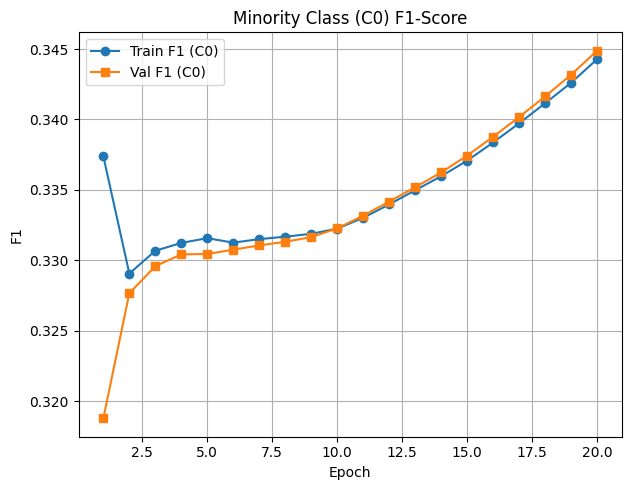

Generating predictions for validation set...


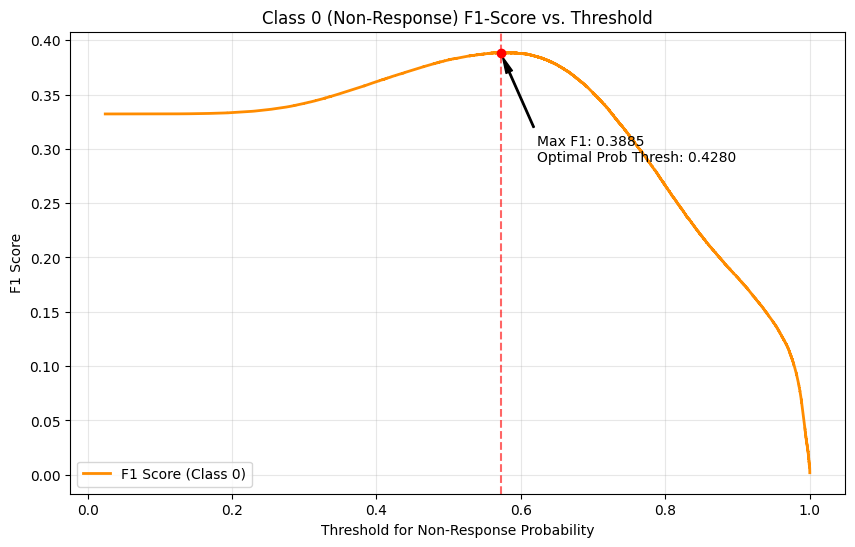


--- THRESHOLD TUNING COMPLETE ---
Optimal Threshold (Original Scale): 0.4280
Max Validation F1 (Class 0):         0.3885


In [50]:
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix
import seaborn as sns

# --- 1. VISUALIZE TRAINING HISTORY ---
def plot_learning_curves(history_path='/Users/adityaponnada/Downloads/time_study_data/training_history.json'):
    with open(history_path, 'r') as f:
        history = json.load(f)
    
    epochs = range(1, len(history['train_f1']) + 1)
    
    plt.figure(figsize=(12, 5))
    
    # F1 Score Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_f1'], 'o-', label='Train F1 (C0)')
    plt.plot(epochs, history['val_f1'], 's-', label='Val F1 (C0)')
    plt.title('Minority Class (C0) F1-Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1')
    plt.legend()
    plt.grid(True)
    
    # We didn't save loss in the last safe-loop, but if you have it:
    # if 'train_loss' in history:
    #     plt.subplot(1, 2, 2)
    #     # plt.plot(epochs, history['train_loss'], label='Train Loss')
    #     plt.plot(epochs, history['val_loss'], label='Val Loss')
    #     plt.title('Model Loss')
    #     plt.xlabel('Epoch')
    #     plt.legend()
    #     plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# --- 2. FIND OPTIMAL THRESHOLD (On Validation Set) ---

def find_optimal_threshold(model, X_val, Y_val):
    """
    Predicts on validation users, finds the threshold that maximizes 
    F1-score for Class 0, and plots the F1 vs. Threshold curve.
    """
    all_probs = []
    all_true = []
    
    print("Generating predictions for validation set...")
    for u in range(len(X_val)):
        # model.predict returns (4, 3967, 1) for one user
        probs = model.predict(X_val[u], verbose=0)
        
        y_true = Y_val[u].flatten()
        y_prob = probs.flatten()
        
        # Remove sentinel values (999.0)
        mask = y_true != 999.0
        all_true.extend(y_true[mask])
        all_probs.extend(y_prob[mask])
    
    all_true = np.array(all_true)
    all_probs = np.array(all_probs)
    
    # --- PR-CURVE LOGIC FOR CLASS 0 ---
    # We invert labels and probabilities because precision_recall_curve 
    # assumes the value provided is for the "positive" class.
    # Original 0 (Non-Response) becomes 1.
    precision, recall, thresholds = precision_recall_curve(1.0 - all_true, 1.0 - all_probs)
    
    # Calculate F1 for each threshold
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-7)
    
    # Find max F1
    best_idx = np.argmax(f1_scores)
    max_f1 = f1_scores[best_idx]
    
    # thresholds array is 1 element shorter than precision/recall
    best_thresh_for_c0 = thresholds[best_idx]
    
    # Convert Class 0 threshold back to original model probability scale (Class 1)
    # If the cutoff for 'Non-Response' is 0.7, the cutoff for 'Response' is 0.3.
    best_threshold_orig = 1.0 - best_thresh_for_c0 

    # --- PLOTTING ---
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, f1_scores[:-1], color='darkorange', lw=2, label='F1 Score (Class 0)')
    
    # Indicate best threshold
    plt.axvline(best_thresh_for_c0, color='red', linestyle='--', alpha=0.6)
    plt.scatter(best_thresh_for_c0, max_f1, color='red', zorder=5)
    
    plt.annotate(f'Max F1: {max_f1:.4f}\nOptimal Prob Thresh: {best_threshold_orig:.4f}', 
                 xy=(best_thresh_for_c0, max_f1), 
                 xytext=(best_thresh_for_c0 + 0.05, max_f1 - 0.1),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))

    plt.title('Class 0 (Non-Response) F1-Score vs. Threshold')
    plt.xlabel('Threshold for Non-Response Probability')
    plt.ylabel('F1 Score')
    plt.legend(loc='lower left')
    plt.grid(alpha=0.3)
    plt.show()
    
    print(f"\n--- THRESHOLD TUNING COMPLETE ---")
    print(f"Optimal Threshold (Original Scale): {best_threshold_orig:.4f}")
    print(f"Max Validation F1 (Class 0):         {max_f1:.4f}")
    
    return best_threshold_orig



# --- EXECUTION FLOW ---
# 1. Load your best model
model = tf.keras.models.load_model('best_model_safe.h5', compile=False)

# 2. Visualize
plot_learning_curves('/Users/adityaponnada/Downloads/time_study_data/training_history.json')

# 3. Tune
opt_thresh = find_optimal_threshold(model, X_test_chunked, Y_test_chunked) # Use your 90-user val set

# 4. Test
# final_test_report(model, X_held_out, Y_held_out, threshold=opt_thresh)

## Held out test data

### Read the held out proceessed data

In [71]:
heldout_df = pd.read_csv('/Users/adityaponnada/Downloads/time_study_data/processed_features_heldout.csv')
heldout_df.head()

,participant_id,outcome,is_weekend,in_battery_saver_mode,charging_status,screen_on,dist_from_home,is_phone_locked,last_phone_usage,closeness_to_sleep_time,...,mi_time_of_day_Night,mi_location_category_Home,mi_location_category_Other,mi_location_category_School,mi_location_category_Transit,mi_location_category_Work,mi_wake_day_part_0.0,mi_wake_day_part_1.0,mi_wake_day_part_2.0,mi_wake_day_part_3.0
0,animateshowerclothes@timestudy_com,1,0,1.0,0.0,1,0.000586,NaN,NaN,860.983333,...,0,0,0,0,0,0,0,0,0,0
1,animateshowerclothes@timestudy_com,0,0,1.0,1.0,1,0.001221,NaN,NaN,838.000000,...,0,0,0,0,0,0,0,0,0,0
2,animateshowerclothes@timestudy_com,0,0,0.0,1.0,1,0.000794,NaN,NaN,827.983333,...,0,0,0,0,0,0,0,0,0,0
3,animateshowerclothes@timestudy_com,0,0,0.0,1.0,1,0.003441,NaN,NaN,817.983333,...,0,0,0,0,0,0,0,0,0,0
4,animateshowerclothes@timestudy_com,0,0,0.0,1.0,1,0.003723,NaN,NaN,781.983333,...,0,0,0,0,0,0,0,0,0,0


In [72]:
heldout_df['participant_id'].nunique()

36

### Impute missing data
Using fill forward approach

In [73]:
heldout_df = impute_test_with_medians_and_ffill(heldout_df, medians, verbose=True)

Imputing 32 columns (excluding {'outcome', 'participant_id'} and prefix "mi_")
Filled 211319 NaNs in column "in_battery_saver_mode" with median 0.0
Filled 211319 NaNs in column "charging_status" with median 0.0
Filled 58787 NaNs in column "dist_from_home" with median 0.0154626683537372
Filled 94616 NaNs in column "is_phone_locked" with median 1.0
Filled 94660 NaNs in column "last_phone_usage" with median 9.1
Filled 147 NaNs in column "closeness_to_sleep_time" with median 464.9166666666667
Filled 147 NaNs in column "closeness_to_wake_time" with median 467.06666666666666
Filled 23990 NaNs in column "mims_5min" with median 30.571034085945772


In [74]:
heldout_df.head()

,participant_id,outcome,is_weekend,in_battery_saver_mode,charging_status,screen_on,dist_from_home,is_phone_locked,last_phone_usage,closeness_to_sleep_time,...,mi_time_of_day_Night,mi_location_category_Home,mi_location_category_Other,mi_location_category_School,mi_location_category_Transit,mi_location_category_Work,mi_wake_day_part_0.0,mi_wake_day_part_1.0,mi_wake_day_part_2.0,mi_wake_day_part_3.0
0,animateshowerclothes@timestudy_com,1,0,1.0,0.0,1,0.000586,1.0,9.1,860.983333,...,0,0,0,0,0,0,0,0,0,0
1,animateshowerclothes@timestudy_com,0,0,1.0,1.0,1,0.001221,1.0,9.1,838.000000,...,0,0,0,0,0,0,0,0,0,0
2,animateshowerclothes@timestudy_com,0,0,0.0,1.0,1,0.000794,1.0,9.1,827.983333,...,0,0,0,0,0,0,0,0,0,0
3,animateshowerclothes@timestudy_com,0,0,0.0,1.0,1,0.003441,1.0,9.1,817.983333,...,0,0,0,0,0,0,0,0,0,0
4,animateshowerclothes@timestudy_com,0,0,0.0,1.0,1,0.003723,1.0,9.1,781.983333,...,0,0,0,0,0,0,0,0,0,0


Only keep the same columns as training set

In [75]:
training_cols = train_df.columns
training_cols
print(len(training_cols))

42


In [76]:
training_cols

Index(['participant_id', 'outcome', 'is_weekend', 'in_battery_saver_mode',
       'charging_status', 'screen_on', 'dist_from_home', 'is_phone_locked',
       'last_phone_usage', 'closeness_to_sleep_time', 'closeness_to_wake_time',
       'mims_5min', 'days_in_study', 'completion_24h', 'completion_1h',
       'time_between_prompts', 'time_since_last_answered',
       'completion_since_wake', 'completion_since_start',
       'time_of_day_Afternoon', 'time_of_day_Early Morning',
       'time_of_day_Evening', 'time_of_day_Late Night', 'time_of_day_Morning',
       'time_of_day_Night', 'location_category_Home',
       'location_category_Other', 'location_category_School',
       'location_category_Transit', 'location_category_Work',
       'wake_day_part_0.0', 'wake_day_part_1.0', 'wake_day_part_2.0',
       'wake_day_part_3.0', 'mi_in_battery_saver_mode', 'mi_charging_status',
       'mi_dist_from_home', 'mi_is_phone_locked', 'mi_last_phone_usage',
       'mi_closeness_to_sleep_time', 'mi_

In [77]:
heldout_df = heldout_df[training_cols]
print(heldout_df.shape[1])
print(heldout_df.shape[0])

42
406382


In [78]:
heldout_df.head()

,participant_id,outcome,is_weekend,in_battery_saver_mode,charging_status,screen_on,dist_from_home,is_phone_locked,last_phone_usage,closeness_to_sleep_time,...,wake_day_part_2.0,wake_day_part_3.0,mi_in_battery_saver_mode,mi_charging_status,mi_dist_from_home,mi_is_phone_locked,mi_last_phone_usage,mi_closeness_to_sleep_time,mi_closeness_to_wake_time,mi_mims_5min
0,animateshowerclothes@timestudy_com,1,0,1.0,0.0,1,0.000586,1.0,9.1,860.983333,...,0,0,0,0,0,1,1,0,0,0
1,animateshowerclothes@timestudy_com,0,0,1.0,1.0,1,0.001221,1.0,9.1,838.000000,...,0,0,0,0,0,1,1,0,0,0
2,animateshowerclothes@timestudy_com,0,0,0.0,1.0,1,0.000794,1.0,9.1,827.983333,...,0,0,0,0,0,1,1,0,0,0
3,animateshowerclothes@timestudy_com,0,0,0.0,1.0,1,0.003441,1.0,9.1,817.983333,...,0,0,0,0,0,1,1,0,0,0
4,animateshowerclothes@timestudy_com,0,0,0.0,1.0,1,0.003723,1.0,9.1,781.983333,...,0,0,0,0,0,1,1,0,0,0


## Scale held out data

In [79]:
heldout_df = z_normalize_test_using_global_mean(heldout_df, global_means, cols_to_scale=None, verbose=True)

Completed z-normalization of test data for columns: ['dist_from_home', 'last_phone_usage', 'closeness_to_sleep_time', 'closeness_to_wake_time', 'mims_5min', 'completion_24h', 'completion_1h', 'time_between_prompts', 'time_since_last_answered', 'completion_since_wake', 'completion_since_start']


In [80]:
heldout_df.head()

,participant_id,outcome,is_weekend,in_battery_saver_mode,charging_status,screen_on,dist_from_home,is_phone_locked,last_phone_usage,closeness_to_sleep_time,...,wake_day_part_2.0,wake_day_part_3.0,mi_in_battery_saver_mode,mi_charging_status,mi_dist_from_home,mi_is_phone_locked,mi_last_phone_usage,mi_closeness_to_sleep_time,mi_closeness_to_wake_time,mi_mims_5min
0,animateshowerclothes@timestudy_com,1,0,1.0,0.0,1,-40.137687,1.0,-0.589123,1.842273,...,0,0,0,0,0,1,1,0,0,0
1,animateshowerclothes@timestudy_com,0,0,1.0,1.0,1,-40.136734,1.0,-0.589123,1.739076,...,0,0,0,0,0,1,1,0,0,0
2,animateshowerclothes@timestudy_com,0,0,0.0,1.0,1,-40.137375,1.0,-0.589123,1.694101,...,0,0,0,0,0,1,1,0,0,0
3,animateshowerclothes@timestudy_com,0,0,0.0,1.0,1,-40.133405,1.0,-0.589123,1.649200,...,0,0,0,0,0,1,1,0,0,0
4,animateshowerclothes@timestudy_com,0,0,0.0,1.0,1,-40.132982,1.0,-0.589123,1.487557,...,0,0,0,0,0,1,1,0,0,0


In [81]:
# simple
heldout_df.to_csv('/Users/adityaponnada/Downloads/time_study_data/general_heldout_scaled.csv', index=False)

## Prep held out tensors

In [101]:
# --- 1. GLOBAL CONSTANTS (Must match Training/Validation) ---
MAX_TIME_SLOTS = obs_len 
L_CHUNK = 3967 
NUM_CHUNKS = 4 
NUM_FEATURES = n_feature_cols # Adjust this if you filtered your features during training
SENTINEL_VALUE = 999.0

# --- 2. PREPROCESSING PIPELINE ---

def preprocess_held_out_data(df):
    """
    Takes a scaled DataFrame and converts it into 4D padded Tensors.
    Assumes scaling has already been applied.
    Returns X_tensor, Y_tensor, and the list of participant_ids.
    """
    print(f"Preprocessing {len(df['participant_id'].unique())} users for final evaluation...")
    
    # A. Padding (Convert DF to 3D Padded Arrays)
    grouped = df.groupby('participant_id')
    X_list, Y_list = [], []
    participant_ids = [] # NEW: List to store IDs in order
    
    for p_id, group in grouped:
        participant_ids.append(p_id) # NEW: Save the ID to maintain the index link
        
        # Features
        X_seq = group.drop(columns=['participant_id', 'outcome']).values 
        X_list.append(X_seq)
        # Targets
        Y_seq = group['outcome'].values.astype('float32').reshape(-1, 1) 
        Y_list.append(Y_seq)

    # Pad Sequences
    X_padded = pad_sequences(X_list, maxlen=MAX_TIME_SLOTS, padding='post', value=SENTINEL_VALUE, dtype='float32')
    Y_padded = pad_sequences(Y_list, maxlen=MAX_TIME_SLOTS, padding='post', value=SENTINEL_VALUE, dtype='float32')
    
    # B. Chunking (Convert 3D -> 4D)
    N_USERS = X_padded.shape[0]
    X_chunked = X_padded.reshape(N_USERS, NUM_CHUNKS, L_CHUNK, X_padded.shape[-1])
    Y_chunked = Y_padded.reshape(N_USERS, NUM_CHUNKS, L_CHUNK, 1)
    
    # C. Create Tensors
    X_tensor = tf.cast(X_chunked, tf.float32)
    Y_tensor = tf.cast(Y_chunked, tf.float32)
    
    print(f"Final Tensor Shape: {X_tensor.shape}")
    # UPDATED: Now returns participant_ids along with the data tensors
    return X_tensor, Y_tensor, participant_ids

In [103]:
X_final, Y_final, heldout_pids = preprocess_held_out_data(heldout_df)

Preprocessing 36 users for final evaluation...
Final Tensor Shape: (36, 4, 3967, 40)


## Load the best model

In [104]:
best_model = tf.keras.models.load_model('best_model_safe.h5', compile=False)

/Users/adityaponnada/Documents/codework/real_time_prompting/real_time_prompting/tfpy/lib/python3.11/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


## Run evaluation

In [105]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
def run_final_test(model, X_held_out, Y_held_out, threshold=0.31):
    """
    X_held_out: 4D Tensor (N, Chunks, L_chunk, Features)
    Y_held_out: 4D Tensor (N, Chunks, L_chunk, 1)
    threshold: The tuned cutoff from the 90-user validation set.
    """
    all_true = []
    all_pred = []
    
    print(f"\nEvaluating Final Test Set with Threshold: {threshold}")
    
    for u in range(len(X_held_out)):
        # Predict on chunks for current user
        probs = model.predict(X_held_out[u], verbose=0)
        
        y_true = Y_held_out[u].numpy().flatten()
        y_prob = probs.flatten()
        
        # Masking: Only evaluate real data points
        mask = y_true != SENTINEL_VALUE
        
        # Binary Decision based on tuned threshold
        # (prob > threshold) => 1 (Response), else 0 (Non-Response)
        preds = (y_prob > threshold).astype(int)
        
        all_true.extend(y_true[mask])
        all_pred.extend(preds[mask])
        
    # --- Final Metrics ---
    print("\n" + "="*40)
    print("      FINAL UNSEEN TEST RESULTS")
    print("="*40)
    print(classification_report(all_true, all_pred, target_names=['Non-Response (C0)', 'Response (C1)']))
    
    # Calculate single F1 value for Class 0 (Non-Response) to return
    final_f1_c0 = f1_score(all_true, all_pred, pos_label=0)
    print(f"\nFinal F1-Score (Class 0): {final_f1_c0:.4f}")
    
    # Plot Confusion Matrix
    cm = confusion_matrix(all_true, all_pred, normalize='true')
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='.2%', cmap='Greens', 
                xticklabels=['Pred C0', 'Pred C1'], 
                yticklabels=['Actual C0', 'Actual C1'])
    plt.title('Final Held-Out Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return final_f1_c0


Evaluating Final Test Set with Threshold: 0.43

      FINAL UNSEEN TEST RESULTS
                   precision    recall  f1-score   support

Non-Response (C0)       0.23      0.77      0.36     70133
    Response (C1)       0.91      0.47      0.62    336249

         accuracy                           0.52    406382
        macro avg       0.57      0.62      0.49    406382
     weighted avg       0.79      0.52      0.57    406382


Final F1-Score (Class 0): 0.3568


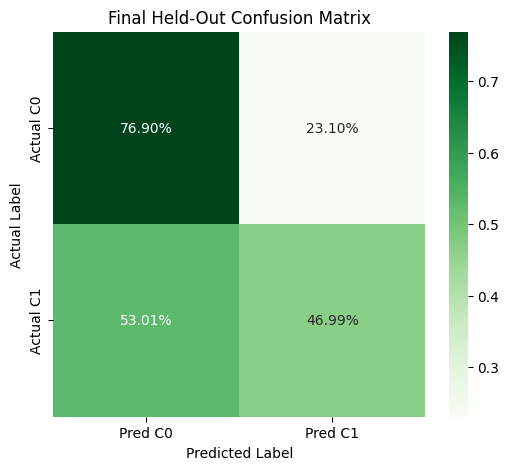

In [106]:
f1_val = run_final_test(best_model, X_final, Y_final, threshold=0.43)

Starting per-user evaluation for 36 participants...

 PER-USER F1 STATS (CLASS 0)
count    36.000000
mean      0.309799
std       0.164582
min       0.036364
25%       0.199537
50%       0.297839
75%       0.371911
max       0.674916
Name: f1_score_c0, dtype: float64


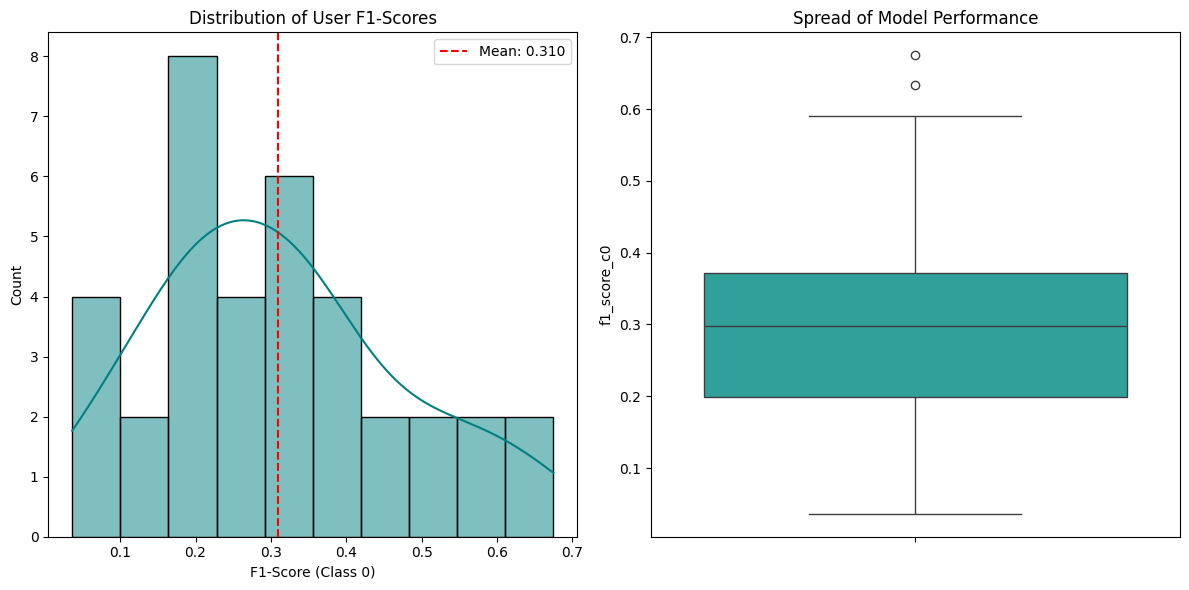

                           participant_id  f1_score_c0
25   quizzicalpremiumfrayed@timestudy_com     0.674916
27    resalepartlyfrigidity@timestudy_com     0.633702
3   bondingcoasterdirtiness@timestudy_com     0.590871
10    dimnesscranialunheard@timestudy_com     0.587876
1       atlanticchefhatchet@timestudy_com     0.521287


In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

def analyze_user_f1_distribution(model, X_held_out, Y_held_out, participant_ids, threshold=0.43):
    """
    Calculates the Class 0 F1-score for each participant individually 
    and visualizes the distribution.
    
    Args:
        model: Trained GTCN model.
        X_held_out: 4D Tensor (N_users, Chunks, L_chunk, Features).
        Y_held_out: 4D Tensor (N_users, Chunks, L_chunk, 1).
        participant_ids: List of strings corresponding to the users in X_held_out.
        threshold: The decision cutoff (e.g., 0.43).
    """
    user_scores = []
    SENTINEL_VALUE = 999.0

    print(f"Starting per-user evaluation for {len(participant_ids)} participants...")

    for u in range(len(X_held_out)):
        # 1. Get predictions for this specific user
        # X_held_out[u] is (Chunks, L_chunk, Features)
        probs = model.predict(X_held_out[u], verbose=0)
        
        y_true = Y_held_out[u].numpy().flatten()
        y_prob = probs.flatten()
        
        # 2. Mask out padding
        mask = y_true != SENTINEL_VALUE
        y_true_real = y_true[mask]
        y_prob_real = y_prob[mask]
        
        # 3. Apply threshold
        y_pred_real = (y_prob_real > threshold).astype(int)
        
        # 4. Calculate F1 for Class 0 (Non-Response)
        # We use zero_division=0 to handle cases where a user might 
        # have zero predicted or actual Class 0s.
        score = f1_score(y_true_real, y_pred_real, pos_label=0, zero_division=0)
        
        user_scores.append({
            'participant_id': participant_ids[u],
            'f1_score_c0': score
        })

    # Convert to DataFrame for easy analysis
    df_scores = pd.DataFrame(user_scores)

    # --- Final Statistics ---
    print("\n" + "="*30)
    print(" PER-USER F1 STATS (CLASS 0)")
    print("="*30)
    print(df_scores['f1_score_c0'].describe())

    # --- Visualization ---
    plt.figure(figsize=(12, 6))
    
    # Histogram & KDE
    plt.subplot(1, 2, 1)
    sns.histplot(df_scores['f1_score_c0'], bins=10, kde=True, color='teal')
    plt.axvline(df_scores['f1_score_c0'].mean(), color='red', linestyle='--', label=f'Mean: {df_scores["f1_score_c0"].mean():.3f}')
    plt.title('Distribution of User F1-Scores')
    plt.xlabel('F1-Score (Class 0)')
    plt.legend()

    # Boxplot to show outliers
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df_scores['f1_score_c0'], color='lightseagreen')
    plt.title('Spread of Model Performance')
    
    plt.tight_layout()
    plt.show()

    return df_scores

# --- Example Usage ---
results_df = analyze_user_f1_distribution(best_model, X_final, Y_final, heldout_pids, threshold=0.31)
print(results_df.sort_values(by='f1_score_c0', ascending=False).head())

In [109]:
low_f1 = results_df[results_df['f1_score_c0'] < 0.1]
low_f1

,participant_id,f1_score_c0
7,congestedculpritsaved@timestudy_com,0.052373
17,idealistsustainerexpansive@timestudy_com,0.098765
20,moisturedecodelyricist@timestudy_com,0.036364
32,subtitlegrievousbazooka@timestudy_com,0.081360


In [110]:
results_df.to_csv('/Users/adityaponnada/Downloads/time_study_data/general_f1_scores.csv', index=False)

## Feature importance

In [117]:
import tqdm

def calculate_permutation_importance(model, X_test_4d, Y_test_4d, feature_names, threshold=0.31):
    """
    Calculates permutation importance for GTCN features. 
    Compatible with both Setup 1 and Setup 2.
    
    Args:
        model: Trained GTCN model (Setup 1 or Setup 2).
        X_test_4d: 4D Tensor/Array (N_users, Chunks, L_chunk, Features).
        Y_test_4d: 4D Tensor/Array (N_users, Chunks, L_chunk, 1).
        feature_names: List of strings for the feature columns.
        threshold: The decision boundary for Class 0 (from your diagnostics).
    """
    print("\n" + "="*50)
    print(f"  FEATURE IMPORTANCE ANALYSIS (Threshold: {threshold})")
    print("="*50)

    # 1. Calculate Baseline F1 (Original Performance)
    all_true, all_base_probs = [], []
    for u in range(len(X_test_4d)):
        probs = model.predict(X_test_4d[u], verbose=0).flatten()
        y_true = Y_test_4d[u]
        if hasattr(y_true, 'numpy'): y_true = y_true.numpy()
        y_true = y_true.flatten()
        mask = y_true != 999.0
        all_true.extend(y_true[mask])
        all_base_probs.extend(probs[mask])
    
    baseline_f1 = f1_score(all_true, (np.array(all_base_probs) > threshold).astype(int), pos_label=0, zero_division=0)
    print(f"Baseline F1 (Class 0): {baseline_f1:.4f}")

    importance_results = []
    
    # 2. Permutation Loop: Shuffle each feature and measure the drop in F1
    for f_idx in tqdm.tqdm(range(len(feature_names)), desc="Analyzing Features"):
        all_perm_probs = []
        
        for u in range(len(X_test_4d)):
            X_orig = X_test_4d[u]
            if hasattr(X_orig, 'numpy'): X_orig = X_orig.numpy()
            
            X_perm = X_orig.copy()
            # Shuffle feature across time for all chunks simultaneously
            for c in range(X_perm.shape[0]):
                np.random.shuffle(X_perm[c, :, f_idx]) 
            
            probs = model.predict(X_perm, verbose=0).flatten()
            y_true = Y_test_4d[u]
            if hasattr(y_true, 'numpy'): y_true = y_true.numpy()
            y_true = y_true.flatten()
            mask = y_true != 999.0
            all_perm_probs.extend(probs[mask])
        
        perm_f1 = f1_score(all_true, (np.array(all_perm_probs) > threshold).astype(int), pos_label=0, zero_division=0)
        
        # Importance is the drop in F1. A high drop means the feature was very important.
        importance = baseline_f1 - perm_f1
        
        importance_results.append({
            'feature': feature_names[f_idx],
            'importance_score': max(0, importance), # Cap at 0 if random noise improves score
            'f1_drop_pct': (importance / baseline_f1) * 100 if baseline_f1 > 0 else 0
        })

    df_importance = pd.DataFrame(importance_results).sort_values(by='importance_score', ascending=False)
    
    print("\nTOP 10 MOST INFLUENTIAL FEATURES:")
    print(df_importance.head(10).to_string(index=False))
    
    return df_importance

In [118]:
feature_list = raw_feature_df_scaled.drop(columns=['participant_id', 'outcome']).columns.tolist()
df_imp = calculate_permutation_importance(model, X_test_chunked, Y_test_chunked, feature_list)
print(df_imp.head(10))


  FEATURE IMPORTANCE ANALYSIS (Threshold: 0.31)


Python(63908) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Baseline F1 (Class 0): 0.3581


Analyzing Features: 100%|██████████| 40/40 [03:08<00:00,  4.71s/it]


TOP 10 MOST INFLUENTIAL FEATURES:
                feature  importance_score  f1_drop_pct
      wake_day_part_0.0          0.060582    16.918773
 location_category_Home          0.057378    16.024181
 time_of_day_Late Night          0.056039    15.650015
      time_of_day_Night          0.056027    15.646667
closeness_to_sleep_time          0.055534    15.509172
      mi_dist_from_home          0.055093    15.385894
              mims_5min          0.055055    15.375242
          completion_1h          0.054289    15.161323
    time_of_day_Evening          0.054051    15.095014
 location_category_Work          0.052390    14.631194
                    feature  importance_score  f1_drop_pct
28        wake_day_part_0.0          0.060582    16.918773
23   location_category_Home          0.057378    16.024181
20   time_of_day_Late Night          0.056039    15.650015
22        time_of_day_Night          0.056027    15.646667
7   closeness_to_sleep_time          0.055534    15.509172
34    